In [ ]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

## The Diet Problem 

Let's try to model a more complicated problem of figuring out caloric requirements for a student who is trying to eat on a budget. We can make this problem quite complicated and have fun with it but for now, we will keep it somewhat simple.  

In order to sustain life, we need to eat carbohydrates and nutrients. Too little nutrients will cause severe health problems as will too much nutrients. Here is the data on the nutrients we need and their limits.

### Diet Problem Data
This data is available as part of our file `diet_nutrients.csv`.  Let's load the file and examine its contents.

In [1]:
import pandas as pd # pandas is a very useful library for loading and processing data
df_nutrients = pd.read_csv('diet_nutrients.csv')
display(df_nutrients)

,name,qmin,qmax
0,Calories,2000,2500
1,Calcium,800,1600
2,Iron,10,30
3,Vit_A,5000,50000
4,Dietary_Fiber,25,100
5,Carbohydrates,0,300
6,Protein,50,100


The file specifies some nutrients and the desired limits. Thus, we would like the student to eat between 2000 and 2500 calories, get between 800-1600 units of Calcium, 10-30 units of iron and so on.
Various foods will provide these nutrients in different amounts.

In [5]:
import pandas as pd # pandas is a very useful library for loading and processing data
df_food_nutrients = pd.read_csv('diet_food_nutrients.csv')
display(df_food_nutrients)

,Food,Calories,Calcium,Iron,Vit_A,Dietary_Fiber,Carbohydrates,Protein
0,Roasted Chicken,277.4,21.9,1.8,77.4,0.0,0.0,42.2
1,Spaghetti W/ Sauce,358.2,80.2,2.3,3055.2,11.6,58.3,8.2
2,"Tomato,Red,Ripe,Raw",25.8,6.2,0.6,766.3,1.4,5.7,1.0
3,"Apple,Raw,W/Skin",81.4,9.7,0.2,73.1,3.7,21.0,0.3
4,Grapes,15.1,3.4,0.1,24.0,0.2,4.1,0.2
5,Chocolate Chip Cookies,78.1,6.2,0.4,101.8,0.0,9.3,0.9
6,Lowfat Milk,121.2,296.7,0.1,500.2,0.0,11.7,8.1
7,Raisin Brn,115.1,12.9,16.8,1250.2,4.0,27.9,4.0
8,Hotdog,242.1,23.5,2.3,0.0,0.0,18.0,10.4


time: 22.8 ms (started: 2023-10-06 13:14:00 +00:00)


Note that we have a list of 9 foods and each of them provides the required nutrients in different amounts. For instance a serving of grapes provides 15.1 calories, 3.4 units of calcium, 0.1 units of iron and so on. 

Another aspect is how much these foods cost and their availability.

In [6]:
import pandas as pd # pandas is a very useful library for loading and processing data
df_foods = pd.read_csv('diet_food.csv')
display(df_foods)

,name,unit_cost,qmin,qmax
0,Roasted Chicken,0.84,0,10
1,Spaghetti W/ Sauce,0.78,0,10
2,"Tomato,Red,Ripe,Raw",0.27,0,10
3,"Apple,Raw,W/Skin",0.24,0,10
4,Grapes,0.32,0,10
5,Chocolate Chip Cookies,0.03,0,10
6,Lowfat Milk,0.23,0,10
7,Raisin Brn,0.34,0,10
8,Hotdog,0.31,0,10


time: 10.8 ms (started: 2023-10-06 13:14:03 +00:00)


Therefore, the goal of the diet problem is to decide how many servings of each food a student must eat so that 
  - The overall cost of the food is minimized
  - The nutritional goals are met.
      - In other words for each nutrient, the student gets the appropriate amount of that nutrient within the specified lower and upper limits.

### Diet Problem LP Formulation: Decision Variables
Suppose there are $n$ foods $F_1, \ldots, F_n$, the decision variables we need are $x_1, \ldots, x_n$ wherein $x_i$ is the number of servings of food $F_i$ that we wish the student to eat. Clearly, we need $x_i \geq 0$ since a student cannot eat a negative amount of food. We are OK with fractions of servings since you could always eat 1/4th of a serving of grapes. Let's create a list of food decision variables: one per food.

In [7]:
from pulp import *
# pulp is a very nice python interface that can work with numerous LP solvers in the backend.
# It allows us a very simple and intuitive interface to write and solve LPs.
# Create the problem and specify that we are minimizing the objective
model = LpProblem("DietProblem", LpMinimize)

#Let's create our decision variables.
num_foods = df_foods.shape[0] # number of rows in data frame = # of foods
#here is a list of all food names
food_names = list(df_foods['name'])
print('The foods are:')
print('\t' ,food_names)

# create a list of food decision variables
food_decision_variables = [LpVariable('x_'+str(j+1), 0.0, None) for j in range(num_foods)]
# Note: the argument 0.0 in creating LpVariable already sets lower bound
# of the variable created to 0.0. No need to add x >= 0 constraint.
# The None argument indicates that no upper bound is needed.


# make a dictionary that maps the variable for each food name. This will be useful
food_name_to_dec_var = {name:var for (name, var) in zip(food_names, food_decision_variables)}
print('The variables are:')
print('\t', food_name_to_dec_var)

The foods are:
	 ['Roasted Chicken', 'Spaghetti W/ Sauce', 'Tomato,Red,Ripe,Raw', 'Apple,Raw,W/Skin', 'Grapes', 'Chocolate Chip Cookies', 'Lowfat Milk', 'Raisin Brn', 'Hotdog']
The variables are:
	 {'Roasted Chicken': x_1, 'Spaghetti W/ Sauce': x_2, 'Tomato,Red,Ripe,Raw': x_3, 'Apple,Raw,W/Skin': x_4, 'Grapes': x_5, 'Chocolate Chip Cookies': x_6, 'Lowfat Milk': x_7, 'Raisin Brn': x_8, 'Hotdog': x_9}
time: 22.4 ms (started: 2023-10-06 13:14:06 +00:00)


### LP Formulation for Diet Problem: Objective Function

The objective function is to minimize the total cost of the food. For each food, we have the cost/serving
data. We need to minimize

$$ c_1 x_1 + \cdots + c_n x_n$$ 

wherein $c_i$ is the given cost/serving of food $F_i$.


In [8]:
obj_fun = sum([df_foods.iloc[j]['unit_cost'] * food_decision_variables[j] for j in range(num_foods)])
print('Objective function:' , obj_fun)
model += obj_fun

Objective function: 0.84*x_1 + 0.78*x_2 + 0.27*x_3 + 0.24*x_4 + 0.32*x_5 + 0.03*x_6 + 0.23*x_7 + 0.34*x_8 + 0.31*x_9
time: 3.49 ms (started: 2023-10-06 13:14:08 +00:00)


### LP Formulation for Diet Problem: Constraints

Next we consider the constraints to be added. Note that for each nutrition, $N_k$ we have two important data items:
  - $l_k, u_k$ the lower and upper limits for how much of the nutrient is needed.
  - $A_{k,i}$ how much of nutrient $N_k$ does food $F_i$ have?
  
The constraints for the nutrient $N_k$ are : 

$$\begin{array}{rl}
A_{k,1} x_1 + A_{k,2} x_2 + \cdots + A_{k,n} x_n & \geq l_k \\ 
A_{k,1} x_1 + A_{k,2} x_2 + \cdots + A_{k,n} x_n & \leq u_k \\ 
\end{array}$$

They express that by eating $x_1$ amount of food $F_1$, $x_2$ of food $F_2$ and so on, a person gets total amount of nutritient $N_k$ within the desired limits. We add these constraints for each nutrient.

In [9]:
all_nutrients = [(row['name'], row['qmin'], row['qmax']) for _, row in df_nutrients.iterrows()]
print('All nutrients: \n\t', all_nutrients)

for (nk,l,u) in all_nutrients:
    # Just restrict ourselves to nutrient `nk`
    nut_terms = ( [ (row['Food'], row[nk]) for (_, row) in df_food_nutrients.iterrows() ])
    nut_lhs_expr = sum( [c*food_name_to_dec_var[name] for (name, c) in nut_terms])
    print(f'Constraints for nutrient: {nk}')
    print(f'\t {nut_lhs_expr} <= {u}')
    model += nut_lhs_expr <= u
    print(f'\t {nut_lhs_expr} >= {l}')
    model += nut_lhs_expr >= l

All nutrients: 
	 [('Calories', 2000, 2500), ('Calcium', 800, 1600), ('Iron', 10, 30), ('Vit_A', 5000, 50000), ('Dietary_Fiber', 25, 100), ('Carbohydrates', 0, 300), ('Protein', 50, 100)]
Constraints for nutrient: Calories
	 277.4*x_1 + 358.2*x_2 + 25.8*x_3 + 81.4*x_4 + 15.1*x_5 + 78.1*x_6 + 121.2*x_7 + 115.1*x_8 + 242.1*x_9 <= 2500
	 277.4*x_1 + 358.2*x_2 + 25.8*x_3 + 81.4*x_4 + 15.1*x_5 + 78.1*x_6 + 121.2*x_7 + 115.1*x_8 + 242.1*x_9 >= 2000
Constraints for nutrient: Calcium
	 21.9*x_1 + 80.2*x_2 + 6.2*x_3 + 9.7*x_4 + 3.4*x_5 + 6.2*x_6 + 296.7*x_7 + 12.9*x_8 + 23.5*x_9 <= 1600
	 21.9*x_1 + 80.2*x_2 + 6.2*x_3 + 9.7*x_4 + 3.4*x_5 + 6.2*x_6 + 296.7*x_7 + 12.9*x_8 + 23.5*x_9 >= 800
Constraints for nutrient: Iron
	 1.8*x_1 + 2.3*x_2 + 0.6*x_3 + 0.2*x_4 + 0.1*x_5 + 0.4*x_6 + 0.1*x_7 + 16.8*x_8 + 2.3*x_9 <= 30
	 1.8*x_1 + 2.3*x_2 + 0.6*x_3 + 0.2*x_4 + 0.1*x_5 + 0.4*x_6 + 0.1*x_7 + 16.8*x_8 + 2.3*x_9 >= 10
Constraints for nutrient: Vit_A
	 77.4*x_1 + 3055.2*x_2 + 766.3*x_3 + 73.1*x_4 + 24.0*x

In [10]:

model.solve()

# Each of the variables is printed with it's resolved optimum value
for f in food_names:
    v = food_name_to_dec_var[f]
    print(f' {f} --> {v.varValue} servings')
print(f'Cost: ${value(model.objective)}')

 Roasted Chicken --> 0.14891116 servings
 Spaghetti W/ Sauce --> 2.1551724 servings
 Tomato,Red,Ripe,Raw --> 0.0 servings
 Apple,Raw,W/Skin --> 0.0 servings
 Grapes --> 0.0 servings
 Chocolate Chip Cookies --> 12.331421 servings
 Lowfat Milk --> 1.8450934 servings
 Raisin Brn --> 0.0 servings
 Hotdog --> 0.0 servings
Cost: $2.6004339584000005
time: 96.2 ms (started: 2023-10-06 13:14:12 +00:00)


## Network Flow Problem

We will now show how to model a problem over graphs: the network flow problem as a linear program.  The network flow problem involves a directed graph $G$ where each edge $e_j$ of the graph has a weight $C_j \geq 0$ that denotes the "capacity" of the edge. There are two specially designated nodes in the graph: the _source_ $s$ and the _sink_ $t$. 
Imagine the graph as a network of pipelines distributing water across a township, connecting the source to the sink where each edge is a pipeline with a capacity $C_j$. Our goal is to send as much water as possible through the pipes:
  - The flow in each edge must be less than its capacity.
  - The flow in each edge must be along the direction of the edge.
  - For each node that is not the source or sink, the sum of flows along edges that are incoming to the node must equal the sum of all flows along outgoing edges. 
    - Note that this constraint does not apply to the source or sink nodes.

The total flow through the network is therefore the total flow leaving the source $s$ or equivalently the total flow entering the sink.

### Example 

Consider the network below with $8$ nodes and a source node $s$/sink node $t$. Along side each edge we have marked the capacity of the edge.

<div>
<img src="flow-network-1.png" width="500"/>
</div>


Here is an example of the flow through the network where the flow across each edge is shown 
in green. Edges without any flow have flow $0$.
<div>
<img src="flow-network-2.png" width="500"/>
</div>
The flow along each edge is in the direction of the edge. Note that for each node other than source/sink, the sum of flow along incoming edges equals that along outgoing edges. The total flow sent through the network equals $8$ which is the flow leaving the source edge or entering the sink.

## Network flow as an LP

We can use linear programming solvers to solve network flow problems over graphs. LPs can solve network flows efficiently although there are dedicated algorithms that are faster for solving network flow problems (eg., see Edmonds-Karp algorithm or Ford-Fulkerson algorithm).

### Input/Output

We are given a directed graph $G$ with 
 - Set of vertices $V$,
 - Set of edges $E \subseteq V \times V$, 
 - For each edge $e \in E$, there we define a capacity $c(e) \geq 0$.
 - We designate two special vertices $s, t \in V$ as the source and sink. 
   - Assume no incoming edges into the source vertex and no outgoing edges from the sink vertex.
   
$\newcommand\incoming{\mathsf{in}}$

$\newcommand\outgoing{\mathsf{out}}$

For each vertex $v \in V$, let $\incoming(v)$ denote all the edges that are incoming into the vertex $v$.
$$\incoming(v) = \{ e \in E \ |\ e \ \text{is of the form}\ (s, v)\ \text{for some vertex}\ s \in V \}$$
Similarly, define $\outgoing(v)$ as the set of all edges outgoing from vertex $v$.

The LP formulation is as follows:
  - Decision Variables: For each edge $e \in E$, add a decision variable $x_e$ denoting the flow through edge $e$.
  - Objective function: We maximize the total flow over all outgoing edges of the source vertex (or alternatively total flow over incoming  edges of the target vertex).
     $$\max\ \sum_{e \in \outgoing(s)}\ x_e$$
  - Capacity Constraints: We have the following constraints for each edge $e \in E$.
  $$\begin{array}{ll}
  x_e \geq 0 & \text{Flow along edge e cannot be negative}\\ 
  x_e \leq c(e) & \text{Flow along edge e must be less than capacity of the edge} \\ 
  \end{array}$$
  - Balance Constraints: we have the following flow balance constraint for each vertex $v \in V \setminus \{s, t\}$:
  $$\begin{array}{ll}
 \sum_{e\in \incoming(v)} x_e = \sum_{e\in \outgoing(v)} x_e 
  \end{array}$$
  
Let's try and program a maximum flow solver using linear programming.  

In [3]:
from pulp import *
import networkx as nx
from matplotlib import pyplot as plt

class WeightedDirectedGraph:
    def __init__(self, num_vertices, source_vertex_id, sink_vertex_id):
        self.__n = num_vertices
        self.__src = source_vertex_id
        self.__sink = sink_vertex_id
        self.__incoming = {}
        self.__outgoing = {}
        self.__edges = []
        self.__flow_lp_vars = []
        self.__lp_model = LpProblem('Flow Problem', LpMaximize)


    def add_edge(self, u, v, cap):
        assert cap > 0.0, 'capacity must be positive'
        assert u != self.__sink, 'Adding an edge leaving sink - not allowed'
        assert v != self.__src, 'Adding an edge entering source - not allowed'
        # Assign a edge id to the edge we are going to add
        edge_id = len(self.__edges)
        # Append the source/dest/capacity
        self.__edges.append( (u,v,cap))
        # Create a new LP variable
        lp_var = LpVariable(f'x_{edge_id}', 0.0, cap) # Create a decision variable with bounds between 0.0 and capacity of edge.
        # Append it to the list of decision variables
        self.__flow_lp_vars.append(lp_var)
        # Add the edge as incoming to vertex v
        if v in self.__incoming:
            self.__incoming[v].append(edge_id)
        else:
            lst = [edge_id]
            self.__incoming[v] = lst
        # add the edge as outgoing to vertex u
        if u in self.__outgoing:
            self.__outgoing[u].append(edge_id)
        else:
            lst=[edge_id]
            self.__outgoing[u] = lst

    # This is a useful routine that uses the networkx library to
    # draw the graph. We provide the option to draw the graph with just edge capacities
    # or to draw the graph showing the flow through each edge.
    def visualize_graph(self, viz_flow = False): # set viz_flow to True only if you calculated the flow.
        G = nx.DiGraph()
        G.add_nodes_from(range(self.__n))
        color_map = ['red' if j == self.__src else ('green' if j == self.__sink else 'blue') for j in range(self.__n)]
        G.add_weighted_edges_from(self.__edges)
        pos=nx.circular_layout(G)
        plt.figure(figsize=(10,5))
        ax = plt.gca()
        title = 'Graph with Edge Capacities' if not viz_flow else 'Graph with Network Flow Solution'
        ax.set_title(f'Graph with {title}')
        nx.draw(G, pos=pos, node_color=color_map, with_labels=True)
        if viz_flow:
            for edge_id in range(len(self.__edges)):
                (u,v,_) = self.__edges[edge_id]
                flow = self.__flow_lp_vars[edge_id].varValue
                G.edges[u,v]['flow'] = flow
            labels = nx.get_edge_attributes(G,'flow')
            nx.draw_networkx_edge_labels(G,pos, edge_labels=labels)

        else:
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G,pos, edge_labels=labels)


    def solve_flow_problem(self):
        # Objective is simply sum of all outgoing variables at source
        # Add the objective to the problem
        s = self.__src
        if s not in self.__outgoing:
            print('Warning: no outgoing edges at source. Max flow is trivially 0 -- bailing out.')
        else:
            lst_of_edge_ids = self.__outgoing[s]
            ob_expr = sum([self.__flow_lp_vars[edge] for edge in lst_of_edge_ids])
            self.__lp_model += ob_expr
        # Add flow balance constraints
        for i in range(self.__n):
            if i != self.__src and i!= self.__sink:
                incoming_lst = self.__incoming[i] if i in self.__incoming else []
                outgoing_lst = self.__outgoing[i] if i in self.__outgoing else []
                total_incoming_flow = sum([self.__flow_lp_vars[edge] for edge in incoming_lst])
                total_outgoing_flow = sum([self.__flow_lp_vars[edge] for edge in outgoing_lst])
                self.__lp_model += total_incoming_flow == total_outgoing_flow
        # Solve the LP
        self.__lp_model.solve()
        # Print the solution
        m = len(self.__edges)
        for i in range(m):
            v = self.__flow_lp_vars[i]
            (x, y, _) = self.__edges[i]
            print(f'Edge: {x} -> {y} : flow is {v.varValue}')
        print(f'Total flow is {value(self.__lp_model.objective)}')

c:\Python312\Lib\site-packages\pulp\pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


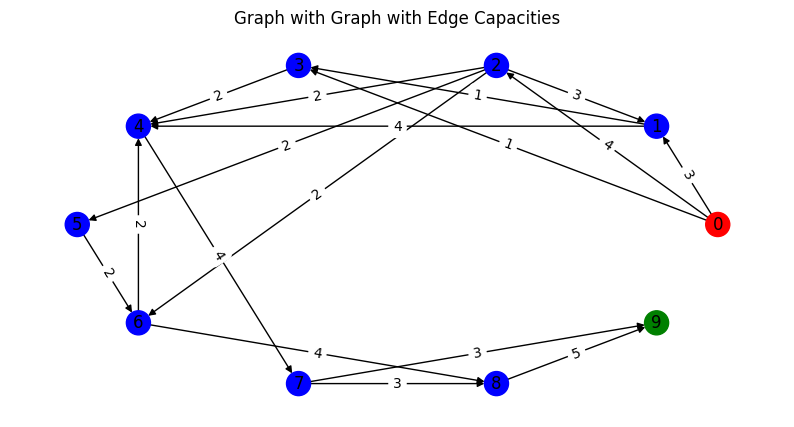

In [5]:
G = WeightedDirectedGraph(10, 0, 9)
G.add_edge(0, 1, 3)
G.add_edge(0, 2, 4)
G.add_edge(0, 3, 1)
G.add_edge(1, 3, 1)
G.add_edge(1, 4, 4)
G.add_edge(2, 1, 3)
G.add_edge(2, 4, 2)
G.add_edge(2, 5, 2)
G.add_edge(2, 6, 2)
G.add_edge(3, 4, 2)
G.add_edge(4, 7, 4)
G.add_edge(5, 6, 2)
G.add_edge(6, 4, 2)
G.add_edge(6, 8, 4)
G.add_edge(7, 8, 3)
G.add_edge(7, 9, 3)
G.add_edge(8, 9, 5)
G.visualize_graph()

Edge: 0 -> 1 : flow is 3.0
Edge: 0 -> 2 : flow is 4.0
Edge: 0 -> 3 : flow is 1.0
Edge: 1 -> 3 : flow is 0.0
Edge: 1 -> 4 : flow is 3.0
Edge: 2 -> 1 : flow is 0.0
Edge: 2 -> 4 : flow is 0.0
Edge: 2 -> 5 : flow is 2.0
Edge: 2 -> 6 : flow is 2.0
Edge: 3 -> 4 : flow is 1.0
Edge: 4 -> 7 : flow is 4.0
Edge: 5 -> 6 : flow is 2.0
Edge: 6 -> 4 : flow is 0.0
Edge: 6 -> 8 : flow is 4.0
Edge: 7 -> 8 : flow is 1.0
Edge: 7 -> 9 : flow is 3.0
Edge: 8 -> 9 : flow is 5.0
Total flow is 8.0


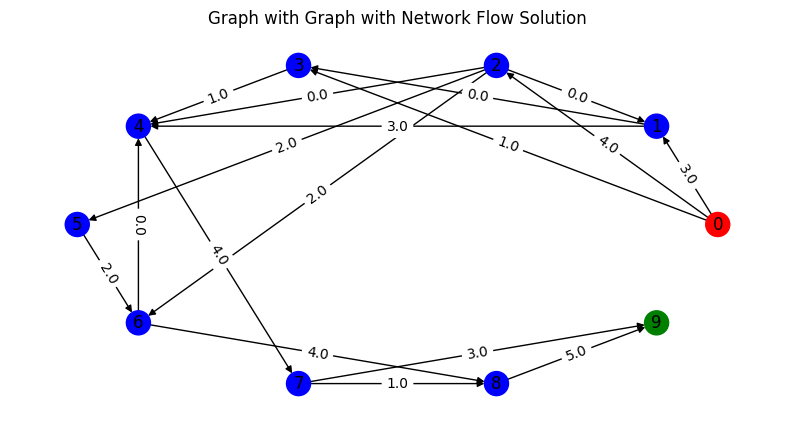

In [6]:
G.solve_flow_problem()
G.visualize_graph(True)

## That's All Folks